In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 256)        1024      
_________________________________________________________________
activation (Activation)      (None, 16000, 256)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 4096000)           16384000  
_________________________________________________________________
dense (Dense)                (None, 16)                65536016  
Total params: 81,922,576
Trainable params: 73,730,064
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 256)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 256)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6028 - acc: 0.5039
Epoch 00001: val_loss improved from inf to 1.27103, saving model to model/checkpoint/1D_CNN_custom_2_BN_6_conv_checkpoint/001-1.2710.hdf5
36805/36805 [==============================] - 452s 12ms/sample - loss: 1.6029 - acc: 0.5039 - val_loss: 1.2710 - val_acc: 0.6184
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0298 - acc: 0.6922
Epoch 00002: val_loss improved from 1.27103 to 0.98342, saving model to model/checkpoint/1D_CNN_custom_2_BN_6_conv_checkpoint/002-0.9834.hdf5
36805/36805 [==============================] - 447s 12ms/sample - loss: 1.0300 - acc: 0.6922 - val_loss: 0.9834 - val_acc: 0.7091
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8385 - acc: 0.7539
Epoch 00003: val_loss improved from 0.98342 to 0.91975, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.0804 - acc: 0.9810
Epoch 00026: val_loss did not improve from 0.45062
36805/36805 [==============================] - 451s 12ms/sample - loss: 0.0806 - acc: 0.9809 - val_loss: 0.5519 - val_acc: 0.8689
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1035 - acc: 0.9721
Epoch 00027: val_loss did not improve from 0.45062
36805/36805 [==============================] - 446s 12ms/sample - loss: 0.1036 - acc: 0.9720 - val_loss: 0.6241 - val_acc: 0.8474
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0890 - acc: 0.9761
Epoch 00028: val_loss did not improve from 0.45062
36805/36805 [==============================] - 443s 12ms/sample - loss: 0.0890 - acc: 0.9761 - val_loss: 0.4791 - val_acc: 0.8791
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9830
Epoch 00029: val_loss did not improve from 0.45062
36805/36805 [==================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9906
Epoch 00056: val_loss did not improve from 0.45062
36805/36805 [==============================] - 446s 12ms/sample - loss: 0.0388 - acc: 0.9905 - val_loss: 0.5722 - val_acc: 0.8833
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9901
Epoch 00057: val_loss did not improve from 0.45062
36805/36805 [==============================] - 451s 12ms/sample - loss: 0.0422 - acc: 0.9901 - val_loss: 0.5143 - val_acc: 0.8875
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9943
Epoch 00058: val_loss did not improve from 0.45062
36805/36805 [==============================] - 448s 12ms/sample - loss: 0.0284 - acc: 0.9943 - val_loss: 0.4777 - val_acc: 0.8968
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9976
Epoch 00059: val_loss did not improve from 0.45062
36805/36805 [=====

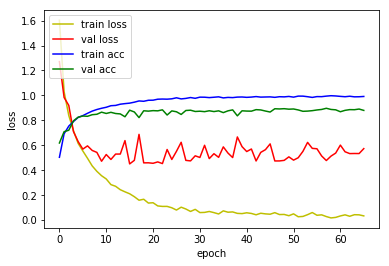

4815/4815 [==============================] - 23s 5ms/sample - loss: 0.5304 - acc: 0.8517
Loss: 0.5303669465541344 Accuracy: 0.8517134

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6536 - acc: 0.4929
Epoch 00001: val_loss improved from inf to 1.18205, saving model to model/checkpoint/1D_CNN_custom_2_BN_7_conv_checkpoint/001-1.1820.hdf5
36805/36805 [==============================] - 450s 12ms/sample - loss: 1.6538 - acc: 0.4929 - val_loss: 1.1820 - val_acc: 0.6464
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9490 - acc: 0.7196
Epoch 00002: val_loss improved from 1.18205 to 0.79584, saving model to model/checkpoint/1D_CNN_custom_2_BN_7_conv_checkpoint/002-0.7958.hdf5
36805/36805 [==============================] - 446s 12ms/sample - loss: 0.9491 - acc: 0.7196 - val_loss: 0.7958 - val_acc: 0.7724
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7123 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0712 - acc: 0.9814
Epoch 00025: val_loss did not improve from 0.21745
36805/36805 [==============================] - 439s 12ms/sample - loss: 0.0715 - acc: 0.9814 - val_loss: 0.2907 - val_acc: 0.9248
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0805 - acc: 0.9778
Epoch 00026: val_loss did not improve from 0.21745
36805/36805 [==============================] - 446s 12ms/sample - loss: 0.0811 - acc: 0.9777 - val_loss: 0.2772 - val_acc: 0.9317
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9724
Epoch 00027: val_loss did not improve from 0.21745
36805/36805 [==============================] - 440s 12ms/sample - loss: 0.0939 - acc: 0.9723 - val_loss: 0.2325 - val_acc: 0.9369
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0660 - acc: 0.9825
Epoch 00028: val_loss did not improve from 0.21745
36805/36805 [==================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9978
Epoch 00054: val_loss did not improve from 0.20548
36805/36805 [==============================] - 446s 12ms/sample - loss: 0.0142 - acc: 0.9977 - val_loss: 0.3025 - val_acc: 0.9271
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9894
Epoch 00055: val_loss did not improve from 0.20548
36805/36805 [==============================] - 442s 12ms/sample - loss: 0.0383 - acc: 0.9893 - val_loss: 0.2652 - val_acc: 0.9366
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9932
Epoch 00056: val_loss did not improve from 0.20548
36805/36805 [==============================] - 440s 12ms/sample - loss: 0.0269 - acc: 0.9931 - val_loss: 0.2438 - val_acc: 0.9429
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9934
Epoch 00057: val_loss did not improve from 0.20548
36805/36805 [=====

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9941
Epoch 00084: val_loss did not improve from 0.20548
36805/36805 [==============================] - 383s 10ms/sample - loss: 0.0233 - acc: 0.9940 - val_loss: 0.2286 - val_acc: 0.9483
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9959
Epoch 00085: val_loss did not improve from 0.20548
36805/36805 [==============================] - 379s 10ms/sample - loss: 0.0168 - acc: 0.9959 - val_loss: 0.2380 - val_acc: 0.9471
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9953
Epoch 00086: val_loss did not improve from 0.20548
36805/36805 [==============================] - 382s 10ms/sample - loss: 0.0181 - acc: 0.9952 - val_loss: 0.2729 - val_acc: 0.9378
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9945
Epoch 00087: val_loss did not improve from 0.20548
36805/36805 [=====

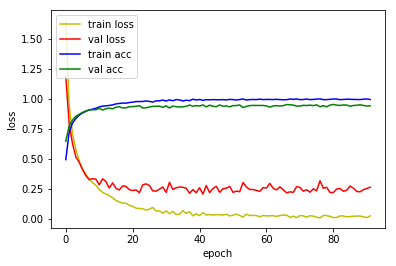

4815/4815 [==============================] - 21s 4ms/sample - loss: 0.2592 - acc: 0.9315
Loss: 0.2591989379496094 Accuracy: 0.9314642

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4926 - acc: 0.5491
Epoch 00001: val_loss improved from inf to 0.83688, saving model to model/checkpoint/1D_CNN_custom_2_BN_8_conv_checkpoint/001-0.8369.hdf5
36805/36805 [==============================] - 391s 11ms/sample - loss: 1.4925 - acc: 0.5491 - val_loss: 0.8369 - val_acc: 0.7547
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7257 - acc: 0.7922
Epoch 00002: val_loss improved from 0.83688 to 0.53370, saving model to model/checkpoint/1D_CNN_custom_2_BN_8_conv_checkpoint/002-0.5337.hdf5
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.7258 - acc: 0.7921 - val_loss: 0.5337 - val_acc: 0.8423
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4992 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9834
Epoch 00026: val_loss did not improve from 0.14186
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0600 - acc: 0.9833 - val_loss: 0.1755 - val_acc: 0.9471
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0528 - acc: 0.9856
Epoch 00027: val_loss improved from 0.14186 to 0.14149, saving model to model/checkpoint/1D_CNN_custom_2_BN_8_conv_checkpoint/027-0.1415.hdf5
36805/36805 [==============================] - 385s 10ms/sample - loss: 0.0528 - acc: 0.9856 - val_loss: 0.1415 - val_acc: 0.9583
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9879
Epoch 00028: val_loss did not improve from 0.14149
36805/36805 [==============================] - 385s 10ms/sample - loss: 0.0456 - acc: 0.9878 - val_loss: 0.1466 - val_acc: 0.9571
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0514 - acc

36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9962
Epoch 00054: val_loss did not improve from 0.12470
36805/36805 [==============================] - 385s 10ms/sample - loss: 0.0162 - acc: 0.9962 - val_loss: 0.1428 - val_acc: 0.9660
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9961
Epoch 00055: val_loss did not improve from 0.12470
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0171 - acc: 0.9960 - val_loss: 0.1724 - val_acc: 0.9536
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9943
Epoch 00056: val_loss did not improve from 0.12470
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0219 - acc: 0.9942 - val_loss: 0.1368 - val_acc: 0.9632
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.12470
36805/36805 [==================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9981
Epoch 00084: val_loss did not improve from 0.12470
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0081 - acc: 0.9981 - val_loss: 0.1425 - val_acc: 0.9665
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9992
Epoch 00085: val_loss did not improve from 0.12470
36805/36805 [==============================] - 384s 10ms/sample - loss: 0.0047 - acc: 0.9992 - val_loss: 0.1350 - val_acc: 0.9686
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9963
Epoch 00086: val_loss did not improve from 0.12470
36805/36805 [==============================] - 385s 10ms/sample - loss: 0.0136 - acc: 0.9963 - val_loss: 0.1556 - val_acc: 0.9637
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9980
Epoch 00087: val_loss did not improve from 0.12470
36805/36805 [=====

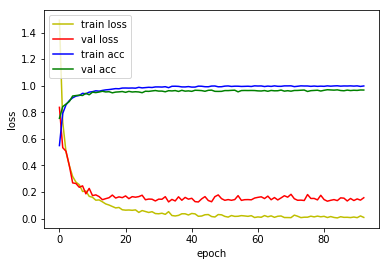

4815/4815 [==============================] - 21s 4ms/sample - loss: 0.1773 - acc: 0.9502
Loss: 0.17725000670286106 Accuracy: 0.95015574

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2466 - acc: 0.6240
Epoch 00001: val_loss improved from inf to 0.61539, saving model to model/checkpoint/1D_CNN_custom_2_BN_9_conv_checkpoint/001-0.6154.hdf5
36805/36805 [==============================] - 402s 11ms/sample - loss: 1.2466 - acc: 0.6240 - val_loss: 0.6154 - val_acc: 0.8332
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5511 - acc: 0.8423
Epoch 00002: val_loss improved from 0.61539 to 0.39369, saving model to model/checkpoint/1D_CNN_custom_2_BN_9_conv_checkpoint/002-0.3937.hdf5
36805/36805 [==============================] - 389s 11ms/sample - loss: 0.5513 - acc: 0.8423 - val_loss: 0.3937 - val_acc: 0.8915
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3836 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9933
Epoch 00027: val_loss did not improve from 0.11844
36805/36805 [==============================] - 388s 11ms/sample - loss: 0.0302 - acc: 0.9932 - val_loss: 0.1326 - val_acc: 0.9616
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9914
Epoch 00028: val_loss did not improve from 0.11844
36805/36805 [==============================] - 400s 11ms/sample - loss: 0.0333 - acc: 0.9914 - val_loss: 0.1394 - val_acc: 0.9611
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9916
Epoch 00029: val_loss did not improve from 0.11844
36805/36805 [==============================] - 386s 10ms/sample - loss: 0.0328 - acc: 0.9916 - val_loss: 0.1242 - val_acc: 0.9644
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9949
Epoch 00030: val_loss did not improve from 0.11844
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9985
Epoch 00056: val_loss did not improve from 0.11303
36805/36805 [==============================] - 387s 11ms/sample - loss: 0.0073 - acc: 0.9985 - val_loss: 0.1476 - val_acc: 0.9618
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9938
Epoch 00057: val_loss did not improve from 0.11303
36805/36805 [==============================] - 387s 11ms/sample - loss: 0.0197 - acc: 0.9938 - val_loss: 0.1373 - val_acc: 0.9646
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9983
Epoch 00058: val_loss did not improve from 0.11303
36805/36805 [==============================] - 387s 11ms/sample - loss: 0.0076 - acc: 0.9983 - val_loss: 0.1607 - val_acc: 0.9602
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9915
Epoch 00059: val_loss did not improve from 0.11303
36805/36805 [==================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9975
Epoch 00086: val_loss did not improve from 0.11303
36805/36805 [==============================] - 399s 11ms/sample - loss: 0.0086 - acc: 0.9975 - val_loss: 0.1584 - val_acc: 0.9606
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9952
Epoch 00087: val_loss did not improve from 0.11303
36805/36805 [==============================] - 400s 11ms/sample - loss: 0.0159 - acc: 0.9952 - val_loss: 0.1458 - val_acc: 0.9646
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9935
Epoch 00088: val_loss did not improve from 0.11303
36805/36805 [==============================] - 399s 11ms/sample - loss: 0.0215 - acc: 0.9935 - val_loss: 0.1412 - val_acc: 0.9637

1D_CNN_custom_2_BN_9_conv Model


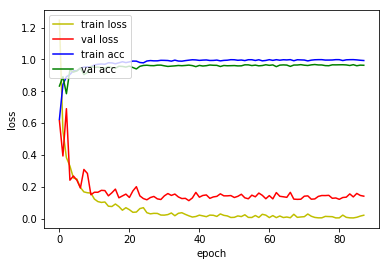

4815/4815 [==============================] - 22s 5ms/sample - loss: 0.1639 - acc: 0.9572
Loss: 0.16386745620368054 Accuracy: 0.95721704



In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_45_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1402896     lambda[0][0]                     
                                                                 lambda_1[0]

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_BN_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_45_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_45_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1402896     lambda[0][0]                     
                                                                 lambda_1[0]